In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.colors as colors

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 

import tqdm
import collections
try:
    import cPickle as pickle
except:
    import pickle

import setigen as stg
import blscint as bls
from blscint.observations.organization import DSFile, DSPointing, DSCadence
from blscint.remote import dsc_cadence 

import scipy.special
import scipy.stats
from astropy.stats import sigma_clip

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import pandas as pd
import sqlite3

import jort
import os
import copy
import shutil
import psutil
from pathlib import Path
import contextlib
import subprocess

import sys 
sys.path.insert(0, '../brkl-111_dedoppler_pipeline')
import survey_direction_filter as sdf

DATA_DIR = Path("/datax2/users/bryanb")
DB_PATH = DATA_DIR / "pipeline.sqlite3"
DIAGSTAT_DIR = DATA_DIR / "scintillation_diagstats"
FIGURES_DIR = Path("/home/bryanb/scintillation_project/scintillation_search_paper/scintillation-search-paper/figures/")

model_frame = stg.Frame.from_backend_params(fchans=256, 
                                            obs_length=600,
                                            int_factor=7)
model_frame.get_params()

{'fchans': 256,
 'tchans': 239,
 'df': 2.7939677238464355,
 'dt': 2.505397589333333,
 'fch1': 6000000000.0,
 'ascending': False}

In [2]:
%matplotlib inline

Completed session 0 (1 of 1)
source /home/bryanb/miniconda3/bin/activate; conda activate bl; python -c 'import tempfile;save_loc = tempfile.gettempdir() + "/bls_remote_cadence.pickle";import blscint as bls;cad = bls.centered_cadence(["/datax2/users/bryanb/blc74_guppi_60103_23850_DIAG_SCINT_GP_L1_B-2_0074.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_24468_DIAG_SCINT_GP_L0_B-2_0075.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_25086_DIAG_SCINT_GP_L1_B-2_0076.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_25704_DIAG_SCINT_GP_L0_B-2_0077.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_26323_DIAG_SCINT_GP_L0_B-1_0078.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_26947_DIAG_SCINT_GP_L0_B1_0079.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_27571_DIAG_SCINT_GP_L0_B-1_0080.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_28196_DIAG_SCINT_GP_L0_B1_0081.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_28815_DIAG_SCINT

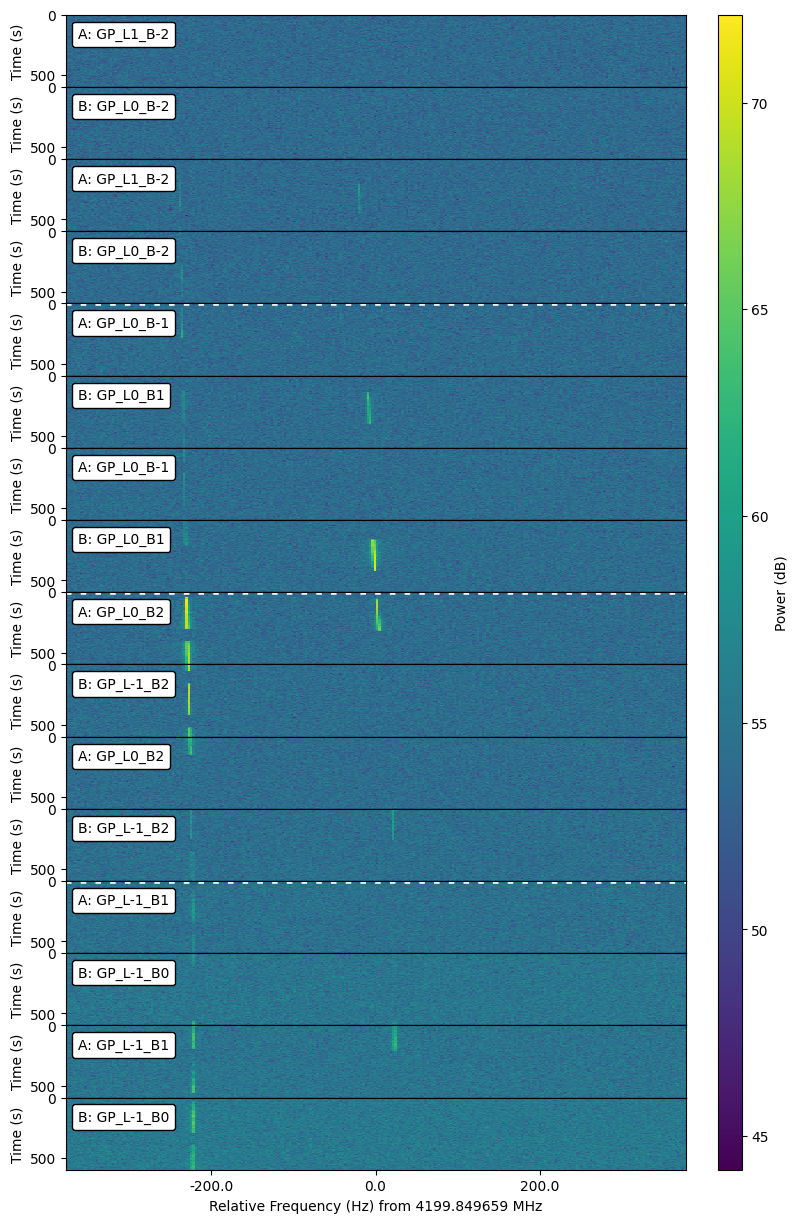

In [27]:
nested_target_list = [
    [
        [
            ["DIAG_SCINT_GP_L1_B-2", "DIAG_SCINT_GP_L0_B-2"],
            ["DIAG_SCINT_GP_L0_B-1", "DIAG_SCINT_GP_L0_B1"],
            ["DIAG_SCINT_GP_L0_B2", "DIAG_SCINT_GP_L-1_B2"],
            ["DIAG_SCINT_GP_L-1_B1", "DIAG_SCINT_GP_L-1_B0"]
        ],
        ["47", "50", "57", "60", "67", "70"]
    ]
]

cadence_list, NGP_pointings = sdf.construct_cadence_list(nested_target_list)
dsc = copy.deepcopy(cadence_list[0])
for cadence in cadence_list[1:]:
    dsc.extend(cadence)

c = dsc_cadence(dsc, 5, 633)
for fr in c:
    fr.source_name = fr.source_name[11:]

plt.figure(figsize=(8, 15))
axs, cax = c.plot(slew_times=False)
plt.sca(axs[2*4])
plt.axhline(0, c='white', lw=4, ls=':')
plt.sca(axs[2*8])
plt.axhline(0, c='white', lw=4, ls=':')
plt.sca(axs[2*12])
plt.axhline(0, c='white', lw=4, ls=':')

plt.savefig(FIGURES_DIR / f'examples_candidate_vetting0.pdf', bbox_inches='tight')
plt.show()

Completed session 0 (1 of 1)
source /home/bryanb/miniconda3/bin/activate; conda activate bl; python -c 'import tempfile;save_loc = tempfile.gettempdir() + "/bls_remote_cadence.pickle";import blscint as bls;cad = bls.centered_cadence(["/datax2/users/bryanb/blc74_guppi_60103_16410_DIAG_SCINT_GP_L2_B1_0062.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_17027_DIAG_SCINT_GP_L2_B2_0063.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_17644_DIAG_SCINT_GP_L2_B1_0064.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_18261_DIAG_SCINT_GP_L2_B2_0065.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_18878_DIAG_SCINT_GP_L1_B2_0066.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_19513_DIAG_SCINT_GP_L1_B1_0067.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_20131_DIAG_SCINT_GP_L1_B2_0068.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_20756_DIAG_SCINT_GP_L1_B1_0069.rawspec.0006.h5","/datax2/users/bryanb/blc74_guppi_60103_26323_DIAG_SCINT_GP_L0

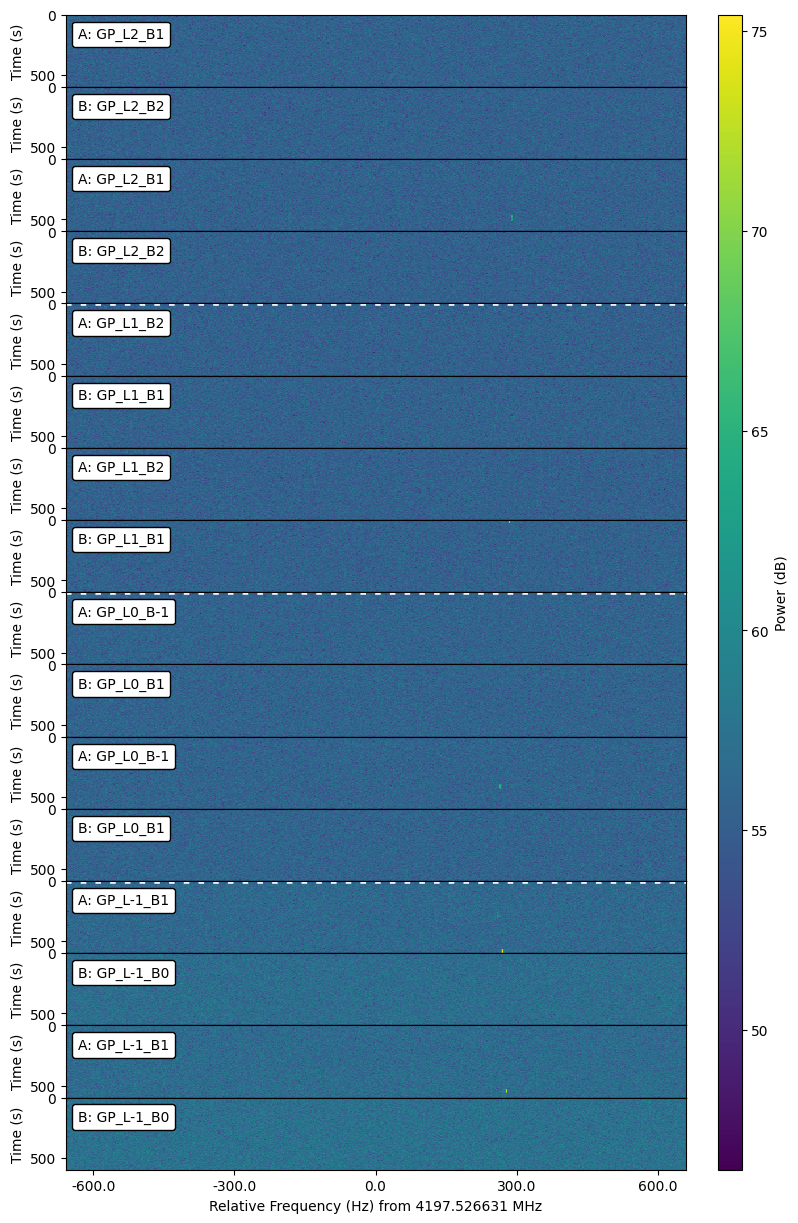

In [28]:
nested_target_list = [
    [
        [
            # ["DIAG_SCINT_GP_L2_B-1", "DIAG_SCINT_GP_L2_B0"],
            ["DIAG_SCINT_GP_L2_B1", "DIAG_SCINT_GP_L2_B2"],
            ["DIAG_SCINT_GP_L1_B2", "DIAG_SCINT_GP_L1_B1"],
            # ["DIAG_SCINT_GP_L1_B0", "DIAG_SCINT_GP_L1_B-1"],
            # ["DIAG_SCINT_GP_L1_B-2", "DIAG_SCINT_GP_L0_B-2"],
            ["DIAG_SCINT_GP_L0_B-1", "DIAG_SCINT_GP_L0_B1"],
            # ["DIAG_SCINT_GP_L0_B2", "DIAG_SCINT_GP_L-1_B2"],
            ["DIAG_SCINT_GP_L-1_B1", "DIAG_SCINT_GP_L-1_B0"]
        ],
        ["47", "50", "57", "60", "67", "70"]
    ]
]

cadence_list, NGP_pointings = sdf.construct_cadence_list(nested_target_list)
dsc = copy.deepcopy(cadence_list[0])
for cadence in cadence_list[1:]:
    dsc.extend(cadence)

c = dsc_cadence(dsc, -2, 635)
for fr in c:
    fr.source_name = fr.source_name[11:]

plt.figure(figsize=(8, 15))
axs, cax = c.plot(slew_times=False)
plt.sca(axs[2*4])
plt.axhline(0, c='white', lw=4, ls=':')
plt.sca(axs[2*8])
plt.axhline(0, c='white', lw=4, ls=':')
plt.sca(axs[2*12])
plt.axhline(0, c='white', lw=4, ls=':')

plt.savefig(FIGURES_DIR / f'examples_candidate_vetting1.pdf', bbox_inches='tight')
plt.show()